In [331]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import TweetTokenizer
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

pd.set_option("max_colwidth", None)

In [137]:
df = pd.read_csv("Sentiment Analysis Dataset.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [34]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(1578612, 4)

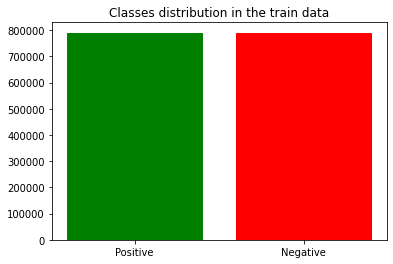

In [44]:
cl = ['Positive', 'Negative']
positive = df[df.Sentiment == 1].Sentiment.sum()
negative = df[df.Sentiment == 0].Sentiment.count()
counts = [positive, negative]
barlist = plt.bar(cl, counts)
barlist[0].set_color('g')
barlist[1].set_color('r')
plt.title('Classes distribution in the train data', fontsize=12)
plt.show()

## Data Cleaning

In [ ]:
tweet_tokenizer = TweetTokenizer()
df["tokenized"] = df["SentimentText"].apply(tweet_tokenizer.tokenize)

In [251]:
def replace_contractions(words):
    cont = {"aren't": 'are not', "can't": 'cannot', "couln't": 'could not', 
        "didn't": 'did not', "doesn't": 'does not', "hadn't": 'had not', 
        "haven't": 'have not', "he's" : 'he is', "she's": 'she is', 
        "he'll": "he will", "she'll": 'she will', "he'd": "he would", 
        "she'd": "she would", "here's": "here is", "i'm": 'i am', 
        "i've": "i have", "i'll": "i will", "i'd": "i would", "isn't": "is not", 
        "it's": "it is", "it'll": "it will", "mustn't": "must not", 
        "shouldn't": "should not", "that's": "that is", "there's": "there is", 
        "they're": "they are", "they've": "they have", "they'll": "they will", 
        "they'd": "they would", "wasn't": "was not", "we're": "we are", 
        "we've": "we have", "we'll": "we will", "we'd": "we would", 
        "weren't": "were not", "what's": "what is", "where's": "where is", 
        "who's": "who is", "who'll":"who will", "won't": "will not", 
        "wouldn't": "would not", "you're": "you are", "you've": "you have",
        "you'll": "you will", "you'd": "you would", "mayn't": "may not"}
    
    reformed = []
    for w in words:
        if w.lower() in cont:
            reformed.append(cont[w.lower()])
        else:
            reformed.append(w)
            
    return reformed

In [270]:
def replace_smileys(words):
  
    emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':D',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

    emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('])  

    reformed = []
    for w in words:
        if w in emoticons_happy:
            reformed.append("happy")
        elif w in emoticons_sad:
            reformed.append("sad") 
        else:
            reformed.append(w)
    t = " ".join([w for w in reformed if len(w)>1])
    return t

In [320]:
def remove_non_chars(sent):
    # remove usernames
    sent = re.sub(r"@[^\s]+", "", sent)
    # remove links
    sent = re.sub(r"(http[^\s]+)|(www\.[^\s]+)", "", sent)
    # remove duplicate characters
    sent = re.sub(r"(?i)(\w)\1{3,}", r"\1", sent)
    sent = re.sub(r"[.,-<]", "", sent)
    return sent

In [321]:
df["reformed"] = df["tokenized"].apply(replace_contractions)
df["reformed"] = df["reformed"].apply(replace_smileys)
df["reformed"] = df["reformed"].apply(remove_non_chars)

In [314]:
df.to_csv("tweeter.csv", index=False)

## Most positive and most negative words extraction

If we just show the words which were most frequent in positive and negative sentences we will only get the most frequent stop-words, let's look at them

In [323]:
positive_sentences = df[df["Sentiment"]==1]["reformed"].tolist()
positive_words = [w for sent in positive_sentences 
                  for w in tweet_tokenizer.tokenize(sent)]
Counter(positive_words).most_common(10)

[('the', 246759),
 ('to', 246678),
 ('you', 178299),
 ('is', 162839),
 ('and', 137909),
 ('it', 136023),
 ('for', 113992),
 ('my', 113507),
 ('in', 95872),
 ('of', 88683)]

In [325]:
negative_sentences = df[df["Sentiment"]==0]["reformed"].tolist()
negative_words = [w for sent in negative_sentences 
                  for w in tweet_tokenizer.tokenize(sent)]
Counter(negative_words).most_common(10)

[('to', 307731),
 ('the', 241863),
 ('is', 183819),
 ('my', 167442),
 ('it', 145638),
 ('and', 143461),
 ('not', 114847),
 ('in', 110731),
 ('am', 104512),
 ('i', 99604)]

to extract trully important words and get rid of stop-words let's use tf-idf method

In [346]:
def tfidf_features(sentences):
    """
        sentences — samples        
        returns TF-IDF vectorized representation of each sample and feature_names
    """
    def custom_tokenize(sent):
        sent = re.sub(r"[^a-zA-Z0-9 ]", "", sent)
        return [w for w in tweet_tokenizer.tokenize(sent.lower()) if len(w) > 1]
    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenize, 
                             min_df = 75, 
                             max_df = 0.4,
                             lowercase=False)
    tfidf_sentences = tfidf_vectorizer.fit_transform(sentences)

    return tfidf_sentences, tfidf_vectorizer.get_feature_names()

In [347]:
tfidf_sentences, feature_names = tfidf_features(df["reformed"])

In [348]:
log_reg = LogisticRegression()
log_reg.fit(tfidf_sentences,df.Sentiment)

LogisticRegression()

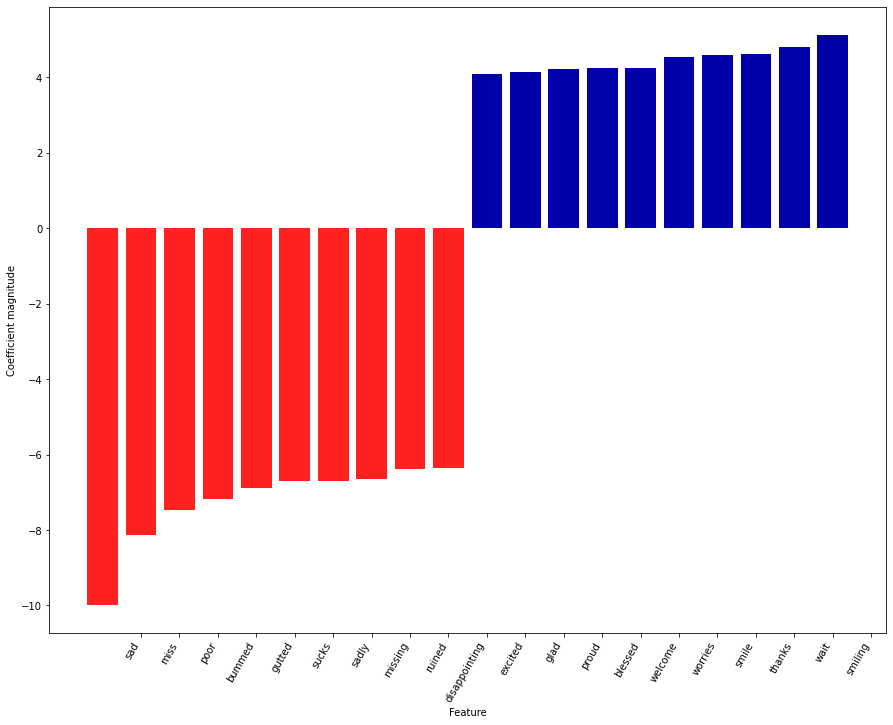

In [349]:
cm = ListedColormap(['#0000aa', '#ff2020'])

coef = log_reg.coef_.ravel()

positive_coefficients = np.argsort(coef)[-10:]
negative_coefficients = np.argsort(coef)[:10]
interesting_coefficients = np.hstack([negative_coefficients,
                                      positive_coefficients])

positive_coefficients = np.argsort(coef)[-10:]
negative_coefficients = np.argsort(coef)[:10]
interesting_coefficients = np.hstack([negative_coefficients,
                                      positive_coefficients])
# plot them
plt.figure(figsize=(15, 15))
colors = [cm(1) if c < 0 else cm(0)
          for c in coef[interesting_coefficients]]
plt.bar(np.arange(2 * 10), coef[interesting_coefficients],
        color=colors)
feature_names = np.array(feature_names)
plt.subplots_adjust(bottom=0.3)
plt.xticks(np.arange(1, 1 + 2 * 10),
           feature_names[interesting_coefficients], rotation=60,
           ha="right")
plt.ylabel("Coefficient magnitude")
plt.xlabel("Feature");

##  Zipf law

In [350]:
WORDS = positive_words + negative_words
COUNTS = Counter(WORDS)

In [383]:
COUNTS.most_common(5)

[('to', 554409),
 ('the', 488622),
 ('is', 346658),
 ('it', 281661),
 ('and', 281370)]

The frequency of any word is inversely proportional to its rank in the frequency table.
To visualize it let's make a log-log-plot. So according to this law we should get the 
line, in our case we can see that we get approzimately the anticipated result

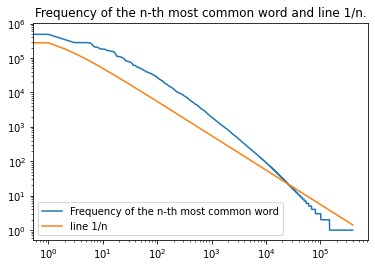

In [389]:
M = COUNTS['to'] # "to" is our most common word, M - it's frequency
plt.yscale('log')
plt.xscale('log')
plt.title('Frequency of the n-th most common word and line 1/n.')
plt.plot([c for (w, c) in COUNTS.most_common()], 
         label="Frequency of the n-th most common word")
plt.plot([M/i for i in range(1, len(COUNTS)+1)], label="line 1/n")
plt.legend();

## Model for classification

In [335]:
train, test = train_test_split(df, test_size=0.15, random_state=42)

x_train = train["reformed"] 
y_train = train["Sentiment"]

x_test = test["reformed"] 
y_test = test["Sentiment"]

In [338]:
def tfidf_features(x_train, x_test):
    """
        x_train, x_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test sets and return the result
    def custom_tokenize(sent):
        sent = re.sub(r"[^a-zA-Z0-9 ]", "", sent)
        return [w for w in tweet_tokenizer.tokenize(sent.lower()) if len(w) > 1]
    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenize, 
                             min_df = 75, 
                             max_df = 0.4,
                             lowercase=False)
    tfidf_vectorizer.fit(x_train)
    x_train = tfidf_vectorizer.transform(x_train)
    x_test = tfidf_vectorizer.transform(x_test)
    return x_train, x_test, tfidf_vectorizer.get_feature_names()

In [339]:
x_train_tfidf, x_test_tfidf, feature_names = tfidf_features(x_train, x_test)

In [340]:
nbc = naive_bayes.MultinomialNB()
nbc.fit(x_train_tfidf,y_train)
# predict the labels on validation dataset
predictions_NB = nbc.predict(x_test_tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  77.34467380654752


In [344]:
log_reg = LogisticRegression()
log_reg.fit(x_train_tfidf,y_train)
predictions_log_reg = log_reg.predict(x_test_tfidf)
# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_log_reg, y_test)*100)

Logistic Regression Accuracy Score ->  79.50521977093821


**To get better results we can**:

1. Find, review and than use a list of stop-word
2. Use SpaCy for lemmatization
3. Use Grid Search to choose best parameters (regularization for Logistic Regression and min_df, max_df parameters for TfidfVectorizer)
4. Experiment with neural networks (different architectures and embeddings)
For example Universal Sentence Encoder + try something like the following: 

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[],
                             output_shape=[512])

from google.colab import drive
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/MyDrive/datasets/tweeter.csv")

train, test = train_test_split(df, test_size=0.15, random_state=42)

x_train = train.reformed.tolist()
y_train = train.Sentiment.values

x_test = test.reformed.tolist()
y_test = test.Sentiment.values

x_train = np.array([str(x) for x in x_train])
x_test = np.array([str(x) for x in x_test])


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),                          
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

def train_model(model, x_train_chunk, y_train_chunk):
    model.fit(x_train_chunk, y_train_chunk, epochs=2, batch_size=128)
    return model

for i in range(50):
    x_train_chunk = x_train[20000*i:20000*(i+1)]
    y_train_chunk = y_train[20000*i:20000*(i+1)]
    x_train_chunk = embed(x_train_chunk)

    model = train_model(model, x_train_chunk, y_train_chunk)

this architecture actually gives us a small improvement in accuracy (80.26%).

We can experiment and improve performance based on a time which we are prepared to spend on the task.